In [1]:
import pandas as pd

## Energy Load

In [2]:
df = pd.read_csv("../data/load_22-24.csv")
# Rename the columns
df = df.rename(columns={'date': 'ds', 'load': 'y'})

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Drop row number 13923/5187  because it is duplicated -> Sumer/Winter Time
df = df.drop(13923)
df = df.drop(5187)
# Keep only 'ds' and 'y' columns
df = df[['ds', 'y']]

In [3]:
# Split the dataframe in a train and test set

# Filter df for the years 2022 and 2023
df_train = df[(df['ds'].dt.year == 2022) | (df['ds'].dt.year == 2023)]
df_test = df[(df['ds'].dt.year == 2024)]

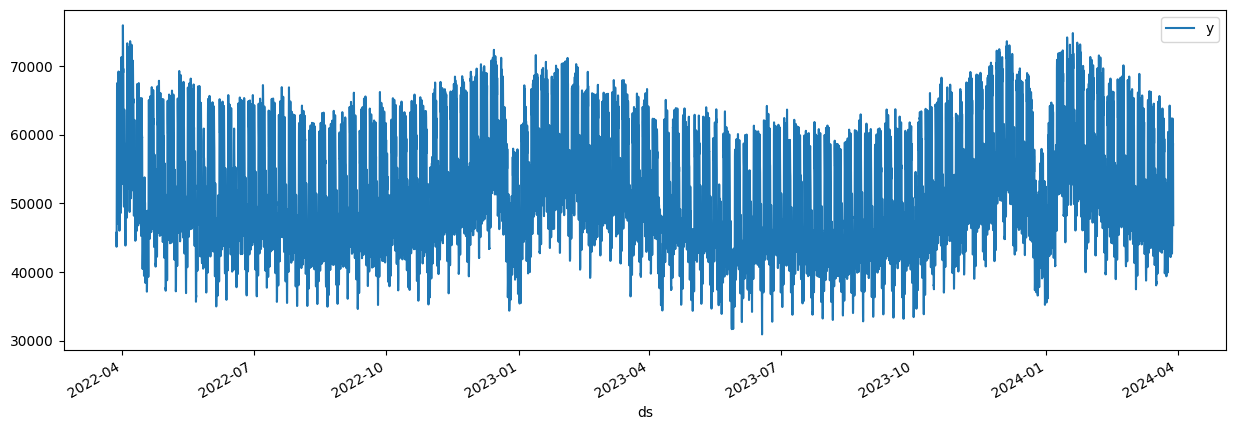

In [4]:
plt = df.plot(x="ds", y="y", figsize=(15, 5))

In [5]:
# Import the NeuralProphet class
from neuralprophet import NeuralProphet, set_log_level

# Disable logging messages unless there is an error
set_log_level("ERROR")

# Create a NeuralProphet model with default parameters
m = NeuralProphet()
# Use static plotly in notebooks
m.set_plotting_backend("plotly-resampler")

In [6]:
# Fit the model on the dataset (this might take a bit)
metrics = m.fit(df_train)

Finding best initial lr:   0%|          | 0/254 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [7]:
# Create a new dataframe reaching (NUMBER OF TRAIN) into the future for our forecast, n_historic_predictions also shows historic data
n = len(df_train)
df_future = m.make_future_dataframe(df_train, n_historic_predictions=True, periods=n)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

Predicting: 242it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'e2ba3edf-db10-4bd6-b3d9-c39d64a94337',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 28, 11, 0),
                          datetime.datetime(2022, 3, 30, 3, 0), ...,
                          datetime.datetime(2025, 10, 4, 3, 0),
                          datetime.datetime(2025, 10, 5, 3, 0),
                          datetime.datetime(2025, 10, 5, 22, 0)], dtype=object),
              'y': array([46474.7109375, 66951.90625  , 50388.609375 , ..., 77224.84375  ,
                          69818.546875 , 82540.9453125])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
    

In [19]:
forecast.iloc[15623:16023]

,ds,y,yhat1,trend,season_weekly,season_daily
15623,2024-01-08 00:00:00,48108.50,45182.937500,57096.230469,-3575.397705,-8337.896484
15624,2024-01-08 01:00:00,46311.25,43943.906250,57098.359375,-3116.782471,-10037.671875
15625,2024-01-08 02:00:00,45961.75,43864.097656,57100.492188,-2659.122559,-10577.271484
15626,2024-01-08 03:00:00,46232.50,44215.226562,57102.625000,-2205.008057,-10682.389648
15627,2024-01-08 04:00:00,47374.50,45280.093750,57104.753906,-1756.942993,-10067.713867
...,...,...,...,...,...,...
16018,2024-01-24 11:00:00,73122.75,68765.671875,57937.789062,3236.488037,7591.400391
16019,2024-01-24 12:00:00,72973.50,68516.093750,57939.921875,3281.611816,7294.567383
16020,2024-01-24 13:00:00,71150.25,67377.750000,57942.046875,3326.012939,6109.694824
16021,2024-01-24 14:00:00,69547.75,66077.601562,57944.179688,3369.020508,4764.401367


In [17]:
df_test.iloc[168:568]['y'].values

array([48108.5 , 46311.25, 45961.75, 46232.5 , 47374.5 , 50624.5 ,
       58452.25, 64605.5 , 67961.  , 69609.  , 70213.  , 70877.  ,
       70678.  , 70062.25, 68881.25, 68121.75, 67999.75, 70167.5 ,
       70023.  , 68831.25, 65464.5 , 62267.5 , 59726.  , 56213.25,
       54127.25, 52184.75, 51452.5 , 51250.  , 52283.75, 55560.  ,
       61859.5 , 67508.75, 70280.25, 71544.  , 71816.75, 71756.25,
       71527.5 , 70108.  , 68451.  , 67551.  , 67617.5 , 70591.25,
       70541.25, 68720.75, 65220.  , 62508.25, 59841.  , 56704.  ,
       54621.25, 52418.25, 51517.5 , 51342.25, 52051.5 , 55273.5 ,
       61618.5 , 67195.  , 70132.25, 71887.5 , 71802.5 , 71554.25,
       70838.  , 69533.5 , 68126.75, 67440.25, 67755.25, 70310.5 ,
       69839.  , 68668.25, 65446.75, 62176.5 , 59633.  , 56738.25,
       54904.5 , 53206.5 , 51625.25, 51708.5 , 52230.  , 55296.75,
       62093.5 , 67780.75, 70563.  , 71501.5 , 71798.75, 71991.25,
       71331.  , 70350.5 , 68511.5 , 67500.25, 68087.25, 70357

In [18]:
forecast.loc[15623:16022,'y'] = df_test.iloc[168:568]['y'].values

In [8]:
df['yhat'] = forecast['yhat1']

In [20]:
# Visualize the forecast
m.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'ffc0838e-970d-48a9-a3ad-d25c9a8ddfb0',
              'x': array([datetime.datetime(2022, 3, 28, 0, 0),
                          datetime.datetime(2022, 3, 28, 11, 0),
                          datetime.datetime(2022, 3, 30, 3, 0), ...,
                          datetime.datetime(2025, 10, 4, 3, 0),
                          datetime.datetime(2025, 10, 5, 3, 0),
                          datetime.datetime(2025, 10, 5, 22, 0)], dtype=object),
              'y': array([46474.7109375, 66951.90625  , 50388.609375 , ..., 77224.84375  ,
                          69818.546875 , 82540.9453125])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
    

In [ ]:
# Calculate residuals
df['residuals'] = df['y'] - df['yhat']

# Remove NaN values from residuals
# residuals = residuals.dropna()

In [ ]:
import matplotlib.pyplot as plt

# Plot residuals
plt.figure(figsize=(10,6))
plt.plot(df['residuals'])
plt.title('Residuals')
plt.show()

In [ ]:
# Save DataFrame to a CSV file
df.to_csv('load_22-24_model-neuralprophet.csv', index=False)

## Energy Peak